In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import timedelta
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, r2_score
from lightgbm import LGBMRegressor
import holidays
import optuna

/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
df = pd.read_csv('../urbanbus_data/SER_0b91_start_aggregated.csv')

df = df.groupby(["Ride_start_datetime", "Bus_Service_Number", "Direction"], as_index=False)["Passenger_Count"].sum()
df['Ride_start_datetime'] = pd.to_datetime(df['Ride_start_datetime'], errors='coerce')
df = df.sort_values('Ride_start_datetime').reset_index(drop=True)

print(f"Total records after aggregation: {len(df):,}")
print(f"Date range: {df['Ride_start_datetime'].min()} to {df['Ride_start_datetime'].max()}\n")
df.head()

Total records after aggregation: 13,572
Date range: 2017-10-01 00:00:00 to 2018-03-31 23:45:00



,Ride_start_datetime,Bus_Service_Number,Direction,Passenger_Count
0,2017-10-01 00:00:00,SER_0b91,Start,2
1,2017-10-01 00:15:00,SER_0b91,Start,1
2,2017-10-01 05:45:00,SER_0b91,Start,21
3,2017-10-01 06:00:00,SER_0b91,Start,37
4,2017-10-01 06:15:00,SER_0b91,Start,48


In [3]:
# Datetime features
df['hour'] = df['Ride_start_datetime'].dt.hour
df['minute'] = df['Ride_start_datetime'].dt.minute
df['day'] = df['Ride_start_datetime'].dt.day
df['dayofweek'] = df['Ride_start_datetime'].dt.dayofweek
df['month'] = df['Ride_start_datetime'].dt.month
df['year'] = df['Ride_start_datetime'].dt.year
df['week_of_year'] = df['Ride_start_datetime'].dt.isocalendar().week

# Cyclic encoding
df['hour_sin'] = np.sin(2 * np.pi * df['hour'] / 24)
df['hour_cos'] = np.cos(2 * np.pi * df['hour'] / 24)
df['minute_sin'] = np.sin(2 * np.pi * df['minute'] / 60)
df['minute_cos'] = np.cos(2 * np.pi * df['minute'] / 60)
df['dow_sin'] = np.sin(2 * np.pi * df['dayofweek'] / 7)
df['dow_cos'] = np.cos(2 * np.pi * df['dayofweek'] / 7)
df['month_sin'] = np.sin(2 * np.pi * df['month'] / 12)
df['month_cos'] = np.cos(2 * np.pi * df['month'] / 12)

# Weekend and holiday flag
df['is_weekend'] = df['dayofweek'].isin([5, 6]).astype(int)
china_holidays = holidays.country_holidays('CN')
df['is_holiday'] = df['Ride_start_datetime'].dt.date.isin(china_holidays).astype(int)

# Peak hour flag
peak_hours = df.groupby('hour')['Passenger_Count'].sum().nlargest(2).index.tolist()
df['is_peak_hour'] = df['hour'].isin(peak_hours).astype(int)

df = df.sort_values('Ride_start_datetime').reset_index(drop=True)

# Lag and window features
for lag in [1, 2, 3, 4, 8, 12, 24]:
    df[f'lag_{lag}'] = df['Passenger_Count'].shift(lag)

for window in [4, 8, 12, 24]:
    shifted_data = df['Passenger_Count'].shift(1)
    df[f'rolling_mean_{window}'] = shifted_data.rolling(window=window, min_periods=1).mean()
    df[f'rolling_std_{window}'] = shifted_data.rolling(window=window, min_periods=1).std()

# Drop rows with NaNs created by the lag/rolling features
lag_roll_cols = [col for col in df.columns if col.startswith(('lag_', 'rolling_'))]
df = df.dropna(subset=lag_roll_cols).reset_index(drop=True)
df = df.fillna(0)

In [4]:
train_calib_df = df[df['Ride_start_datetime'] < df['Ride_start_datetime'].max() - timedelta(days=28)].copy()
test_df = df[df['Ride_start_datetime'] >= df['Ride_start_datetime'].max() - timedelta(days=28)].copy()

train_df = train_calib_df[train_calib_df['Ride_start_datetime'] < train_calib_df['Ride_start_datetime'].max() - timedelta(days=21)].copy()
calib_df = train_calib_df[train_calib_df['Ride_start_datetime'] >= train_calib_df['Ride_start_datetime'].max() - timedelta(days=21)].copy()

print(f"\nTraining Set: {len(train_df):,} records ({train_df['Ride_start_datetime'].min()} to {train_df['Ride_start_datetime'].max()})")
print(f"Calibration Set: {len(calib_df):,} records ({calib_df['Ride_start_datetime'].min()} to {calib_df['Ride_start_datetime'].max()})")
print(f"Validation Set: {len(test_df):,} records ({test_df['Ride_start_datetime'].min()} to {test_df['Ride_start_datetime'].max()})")


Training Set: 9,884 records (2017-10-01 11:15:00 to 2018-02-10 23:15:00)
Calibration Set: 1,568 records (2018-02-10 23:30:00 to 2018-03-03 23:30:00)
Validation Set: 2,096 records (2018-03-03 23:45:00 to 2018-03-31 23:45:00)


In [5]:
cat_cols = ['Bus_Service_Number', 'Direction']
num_cols = [
    'hour', 'minute', 'day', 'dayofweek', 'month', 'year', 'week_of_year',
    'hour_sin', 'hour_cos', 'minute_sin', 'minute_cos', 'dow_sin', 'dow_cos',
    'month_sin', 'month_cos', 'is_weekend', 'is_holiday', 'is_peak_hour'
]
lag_roll_cols = [col for col in train_df.columns if col.startswith(('lag_', 'rolling_'))]
features = num_cols + lag_roll_cols

X_train = train_df[features].copy()
y_train = train_df['Passenger_Count'].copy()
X_calib = calib_df[features].copy()
y_calib = calib_df['Passenger_Count'].copy()
X_test = test_df[features].copy()
y_test = test_df['Passenger_Count'].copy()

print(f"\nFeature matrices prepared:")
print(f"  X_train: {X_train.shape}")
print(f"  X_calib: {X_calib.shape}")
print(f"  X_val: {X_test.shape}")


Feature matrices prepared:
  X_train: (9884, 33)
  X_calib: (1568, 33)
  X_val: (2096, 33)


In [6]:
tscv = TimeSeriesSplit(n_splits=3)

def objective(trial):
    params = {
        "objective": "regression",
        "n_estimators": trial.suggest_int("n_estimators", 100, 500),
        "max_depth": trial.suggest_int("max_depth", 3, 8),
        "num_leaves": trial.suggest_int("num_leaves", 15, 40),
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.1, log=True),
        "min_child_samples": trial.suggest_int("min_child_samples", 20, 150),
        "subsample": trial.suggest_float("subsample", 0.5, 0.9),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.5, 0.9),
        "reg_alpha": trial.suggest_float("reg_alpha", 0.1, 10.0, log=True),
        "reg_lambda": trial.suggest_float("reg_lambda", 0.1, 10.0, log=True),
        "random_state": 42,
        "verbose": -1
    }
    
    fold_mae = []
    for train_idx, val_idx in tscv.split(X_train):
        X_tr, X_val = X_train.iloc[train_idx], X_train.iloc[val_idx]
        y_tr, y_val = y_train.iloc[train_idx], y_train.iloc[val_idx]
        
        model = LGBMRegressor(**params)
        model.fit(X_tr, y_tr)
        
        preds = model.predict(X_val)
        fold_mae.append(mean_absolute_error(y_val, preds))
    
    return np.mean(fold_mae)

study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=30)
best_params = study.best_params

[I 2025-11-25 12:46:21,450] A new study created in memory with name: no-name-513085bf-d783-4db5-b143-a56783b97de0
[I 2025-11-25 12:46:23,355] Trial 0 finished with value: 12.952068591989699 and parameters: {'n_estimators': 193, 'max_depth': 7, 'num_leaves': 25, 'learning_rate': 0.03938597137145987, 'min_child_samples': 37, 'subsample': 0.6009395043863787, 'colsample_bytree': 0.811290050790929, 'reg_alpha': 0.24645644329029676, 'reg_lambda': 0.1788132689440967}. Best is trial 0 with value: 12.952068591989699.
[I 2025-11-25 12:46:28,793] Trial 1 finished with value: 12.849702665587879 and parameters: {'n_estimators': 399, 'max_depth': 8, 'num_leaves': 40, 'learning_rate': 0.015619975335822604, 'min_child_samples': 28, 'subsample': 0.8400438426652047, 'colsample_bytree': 0.7080998964171933, 'reg_alpha': 0.959168361679416, 'reg_lambda': 0.3347334430681557}. Best is trial 1 with value: 12.849702665587879.
[I 2025-11-25 12:46:31,360] Trial 2 finished with value: 13.195497441754968 and parame

In [7]:
models = {}
for alpha in [0.1, 0.5, 0.9]:
    quantile_params = best_params.copy()
    quantile_params.update({"objective": "quantile", "alpha": alpha})
    model = LGBMRegressor(**quantile_params)
    model.fit(X_train, y_train)
    models[alpha] = model

In [8]:
cal_lower = models[0.1].predict(X_calib)
cal_upper = models[0.9].predict(X_calib)
scores = np.maximum(0, np.maximum(cal_lower - y_calib, y_calib - cal_upper))

alpha_cqr = 0.1
q_hat = np.quantile(scores, 1 - alpha_cqr)
print(f"q_hat: {q_hat:.3f}")

q_hat: 7.427


In [9]:
y_pred_lower = models[0.1].predict(X_test) - q_hat
y_pred_upper = models[0.9].predict(X_test) + q_hat
y_pred_median = models[0.5].predict(X_test)


results_df = pd.DataFrame({
    'Ride_start_datetime': test_df['Ride_start_datetime'].values,
    'Actual': y_test.values,
    'Prediction': y_pred_median,
    'Lower_Bound': y_pred_lower,
    'Upper_Bound': y_pred_upper
})

In [10]:
def evaluate_conformal_predictions(results_df, alpha=0.1):
    df = results_df.copy()
    df['interval_width'] = df['Upper_Bound'] - df['Lower_Bound']
    df['covered'] = ((df['Actual'] >= df['Lower_Bound']) &
                     (df['Actual'] <= df['Upper_Bound'])).astype(int)

    coverage = df['covered'].mean()                    
    avg_width = df['interval_width'].mean()        
    mae = mean_absolute_error(df['Actual'], df['Prediction'])
    mape = mean_absolute_percentage_error(df['Actual'], df['Prediction'])
    r2 = r2_score(df['Actual'], df['Prediction'])

    metrics = {
        'empirical_coverage': round(coverage, 3)*100,
        'coverage_error': round(coverage - (1 - alpha), 3),
        'avg_interval_width': round(avg_width, 3),
        'MAE': round(mae, 3),
        'MAPE': round(mape, 3),
        'R2_Score': round(r2, 3)
    }

    print("\nCP evaluation metrics:")
    for k, v in metrics.items():
        print(f"{k:25s}: {v}")

    return metrics

metrics = evaluate_conformal_predictions(results_df, alpha=0.1)



CP evaluation metrics:
empirical_coverage       : 90.8
coverage_error           : 0.008
avg_interval_width       : 52.533
MAE                      : 12.059
MAPE                     : 0.233
R2_Score                 : 0.854


In [11]:
import plotly.graph_objects as go

sample = results_df.head(500).sort_values('Ride_start_datetime')

fig = go.Figure()
fig.add_traces([
    go.Scatter(
        x=sample.index,
        y=sample['Upper_Bound'],
        mode='lines',
        line=dict(width=0),
        showlegend=False,
        hoverinfo='skip'
    ),
    go.Scatter(
        x=sample.index,
        y=sample['Lower_Bound'],
        mode='lines',
        fill='tonexty',
        fillcolor='rgba(135, 206, 250, 0.3)',
        line=dict(width=0),
        name='90% Conformal Prediction Interval',
        hoverinfo='skip'
    )
])

# --- Add Median Prediction ---
fig.add_trace(go.Scatter(
    x=sample.index,
    y=sample['Prediction'],
    mode='lines',
    name='Median Prediction',
    line=dict(color='orange', width=2),
    hovertemplate=(
        "Prediction: %{y:.2f}<br>"
        "Lower Bound: %{customdata[0]:.2f}<br>"
        "Upper Bound: %{customdata[1]:.2f}<extra></extra>"
    ),
    customdata=np.stack([sample['Lower_Bound'], sample['Upper_Bound']], axis=-1)
))

# --- Add Actual Values ---
fig.add_trace(go.Scatter(
    x=sample.index,
    y=sample['Actual'],
    mode='markers',
    name='Actual',
    marker=dict(color='blue', size=5, opacity=0.6)
))

fig.update_layout(
    title='Conformal Prediction Intervals',
    xaxis_title='Sample Index',
    yaxis_title='Passenger Count',
    template='plotly_white',
    legend=dict(
        orientation='h',
        yanchor='bottom',
        y=-0.25,
        xanchor='center',
        x=0.5
    ),
    hovermode='x unified',
    width=950,
    height=500
)

fig.show()


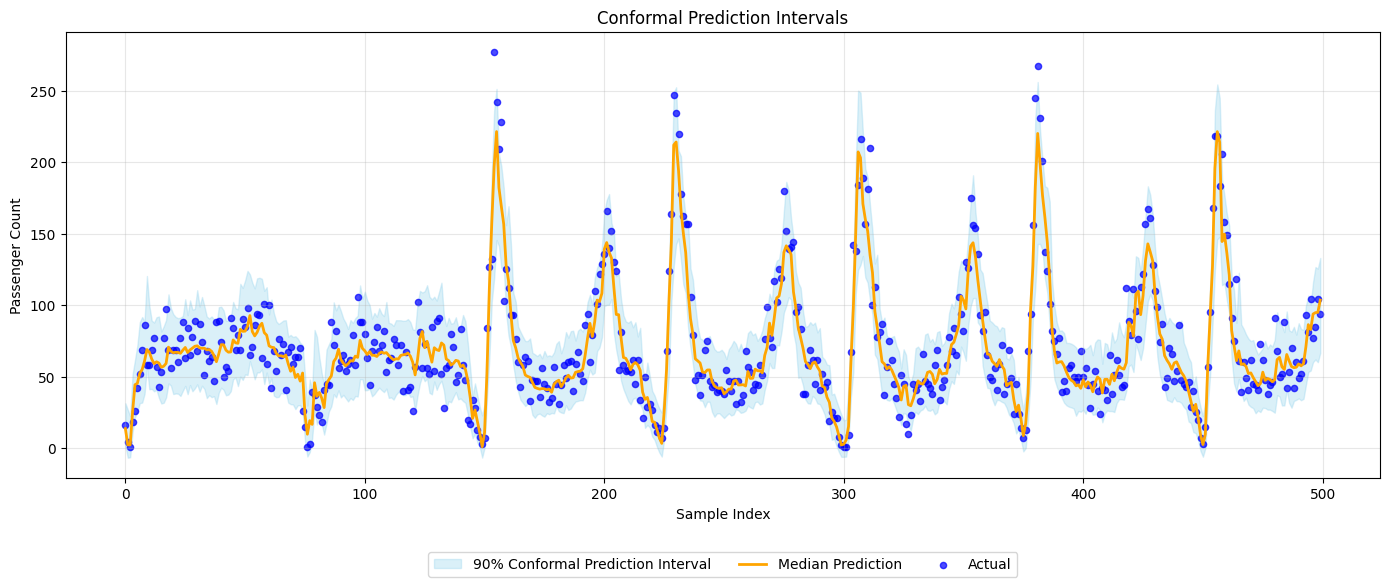

In [13]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Select sample (as in original code)
sample = results_df.head(500).sort_values('Ride_start_datetime').reset_index(drop=True)

plt.figure(figsize=(14, 6))

# --- Plot Conformal Interval (Shaded Region) ---
plt.fill_between(
    sample.index,
    sample['Lower_Bound'],
    sample['Upper_Bound'],
    color='skyblue',
    alpha=0.3,
    label='90% Conformal Prediction Interval'
)

# --- Plot Median Prediction ---
plt.plot(
    sample.index,
    sample['Prediction'],
    color='orange',
    linewidth=2,
    label='Median Prediction'
)

# --- Plot Actual Values ---
plt.scatter(
    sample.index,
    sample['Actual'],
    color='blue',
    s=20,
    alpha=0.7,
    label='Actual'
)

# --- Plot Formatting ---
plt.title('Conformal Prediction Intervals')
plt.xlabel('Sample Index')
plt.ylabel('Passenger Count')
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), ncol=3)
plt.grid(True, alpha=0.3)
plt.tight_layout()

plt.show()
